# 📈FOREX Trend Predictions - LSTM approach
---
This notebook is the sequel of my previous notebook: [📈FOREX Trend Predictions - Classic ML approach](https://www.kaggle.com/code/paulbacher/forex-trend-predictions-classic-ml-approach)

It will show how to create a **LSTM deep-learning model** that attempts to predict trends in the FOREX market. Price forecasting is a very advanced technique, so we will only classify trends as either up, down, or undetermined. Here is a brief summary of what will be accomplished:
- Download historical data up until today's date
- Create useful features that could help the model
- Train a LSTM classifier and try to predict the next trend
- Evaluate the model and present some mistakes

[**Long Short-Term Memory (LSTM)**](https://towardsdatascience.com/lstm-recurrent-neural-networks-how-to-teach-a-network-to-remember-the-past-55e54c2ff22e) is a type of **recurrent neural network (RNN)** that is widely used for sequential data analysis. They are designed to capture long-term dependencies in time-series data, making them particularly suitable for forecasting trends in forex. These models work by processing input sequences of data over time and updating an internal state called the "cell state" with each new input. This cell state allows the model to remember important information from earlier time steps and use it to inform its predictions at later time steps. In the context of forex forecasting, LSTM models can be trained on historical forex data to learn patterns and trends that can then be used to predict future price movements.

## References:
[Code Trading](https://www.youtube.com/@CodeTradingCafe) on YouTube

# Imports

In [1]:
!pip install yfinance
!pip install pandas_ta

import numpy as np
import pandas as pd
import pandas_ta as ta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import yfinance as yf

from scipy.stats import linregress
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import TimeSeriesSplit

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Activation, Dropout
from tensorflow.keras.optimizers import Adam

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None)

from IPython.display import clear_output
clear_output()

# Preparing the data for the model
- Download the forex data with `yahoo-finance` and only keep the `Open`, `High`, `Low` and `Close` columns.
- Create time dependant feature indicators with the `pandas_ta` library. For example the RSI, and some moving averages.
- Create the targets we want to predict: the next close price.
- Scale the data to feed in the neural network.
- Create the X and y arrays. X is a 3d array with the number of examples, the number of days we look backward for the recurrence, and the features.
- Split the data for validation.

In [2]:
# Load online data
df = yf.download(tickers='EURUSD=X',
                 period='3000d',
                 interval='1d')
df = df.drop(['Volume', 'Adj Close'], axis=1)


# Create new features
FEATURES = ['Open', 'High', 'Low', 'Close', 'RSI', 'EMA20', 'EMA100', 'EMA150']
df['RSI'] = ta.rsi(df.Close, length=15)
df['EMA20'] = ta.ema(df.Close, length=20)
df['EMA100'] = ta.ema(df.Close, length=100)
df['EMA150'] = ta.ema(df.Close, length=150)

# Create the targets
df['Target'] = df.Close - df.Open
df['Target'] = df.Target.shift(-1)
df['TargetClass'] = [1 if df.Target[i] > 0 else 0 for i in range(len(df))]
df['TargetNextClose'] = df.Close.shift(-1)

# Drop NaN rows
df = df.dropna()

# Scale the data
df_set = df.copy()
df_set = df_set.reset_index(drop=True)
scaler = MinMaxScaler(feature_range=(0, 1))
df_set = scaler.fit_transform(df_set)

# Create X and y arrays
X = []
backcandles = 30
for j in range(len(FEATURES)):
    X.append([])
    for i in range(backcandles, df_set.shape[0]):
        X[j].append(df_set[i - backcandles : i, j])
X = np.moveaxis(X, 0, 2)
y = df_set[backcandles:, -1].reshape(-1, 1)

# Split the data
split_limit = int(len(X) * 0.8)
X_train, X_test = X[:split_limit], X[split_limit:]
y_train, y_test = y[:split_limit], y[split_limit:]
print("X_train:", X_train.shape)
print("X_test: ", X_test.shape)
print("y_train:", y_train.shape)
print("y_test: ", y_test.shape)

[*********************100%***********************]  1 of 1 completed
X_train: (2252, 30, 8)
X_test:  (563, 30, 8)
y_train: (2252, 1)
y_test:  (563, 1)


# Keras LSTM model
We use now the Keras API to create a LSTM neural network. We are using a linear activation because it is a regression task.

In [3]:
inputs = Input(shape=(backcandles, len(FEATURES)), name='lstm_input')
x = LSTM(150, name='first_layer')(inputs)
x = Dense(1, name='dense_layer')(x)
outputs = Activation('linear', name='output')(x)

model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=Adam(), loss='mse')
model.fit(
    x=X_train,
    y=y_train,
    batch_size=16,
    epochs=30,
    shuffle=True,
    validation_split=0.1
)

Epoch 1/30
127/127 [==============================] - 6s 32ms/step - loss: 0.0057 - val_loss: 6.4520e-04
Epoch 2/30
127/127 [==============================] - 4s 28ms/step - loss: 5.5888e-04 - val_loss: 6.2988e-04
Epoch 3/30
127/127 [==============================] - 3s 27ms/step - loss: 5.1910e-04 - val_loss: 4.7969e-04
Epoch 4/30
127/127 [==============================] - 4s 28ms/step - loss: 4.7752e-04 - val_loss: 6.3224e-04
Epoch 5/30
127/127 [==============================] - 4s 28ms/step - loss: 5.0396e-04 - val_loss: 4.4386e-04
Epoch 6/30
127/127 [==============================] - 4s 28ms/step - loss: 4.7839e-04 - val_loss: 4.4238e-04
Epoch 7/30
127/127 [==============================] - 3s 27ms/step - loss: 4.4875e-04 - val_loss: 3.9625e-04
Epoch 8/30
127/127 [==============================] - 4s 28ms/step - loss: 4.8038e-04 - val_loss: 4.2156e-04
Epoch 9/30
127/127 [==============================] - 4s 28ms/step - loss: 4.6824e-04 - val_loss: 3.7723e-04
Epoch 10/30
127/127 [==

# Results
It is time to make our predictions. **I want to highlight some common mistakes that I will explain at the end.**

For now, let's just plot the results.

In [4]:
# Predictions
test_length = len(X_test)
y_pred = model.predict(X_test)
pred_df = pd.DataFrame(df_set[-test_length:], index=df.index[-test_length:], columns=df.columns)
pred_df.TargetNextClose = y_pred
pred_df = scaler.inverse_transform(pred_df)
pred_df = pd.DataFrame(pred_df, index=df.index[-test_length:], columns=df.columns)

# Absolute true and predicted
abs_pred = pred_df.TargetNextClose
abs_true = df[-test_length:].TargetNextClose

# Relative true and predicted
rel_true = df.Target[-test_length:]
rel_pred = pred_df.TargetNextClose - pred_df.Open

18/18 [==============================] - 1s 13ms/step


## Plot the predicted close prices

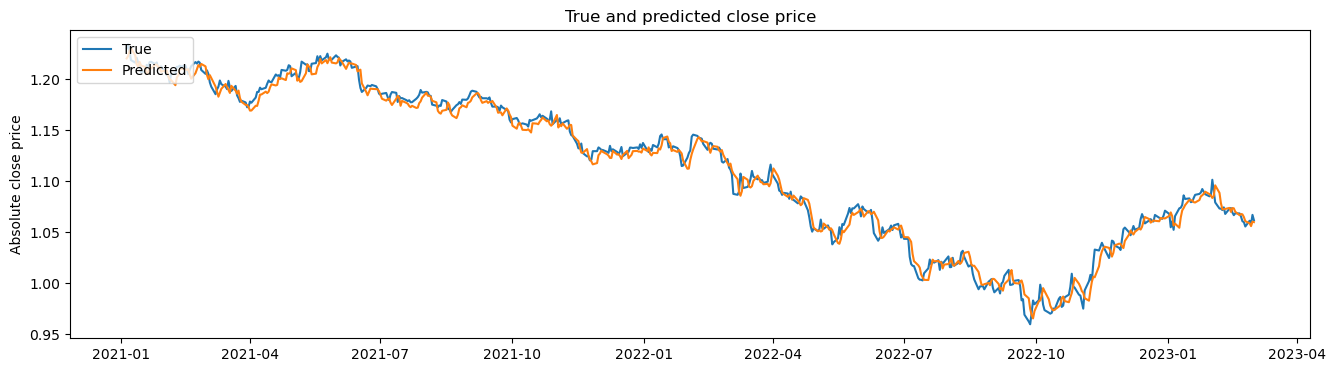

In [5]:
# Display
plt.figure(figsize=(16, 4))
plt.plot(abs_true)
plt.plot(abs_pred)
plt.legend(["True", "Predicted"], loc='upper left')
plt.title("True and predicted close price")
plt.ylabel("Absolute close price")
plt.show()

When examining this graph, one might conclude that the LSTM model performed very well since both curves are close. However, **this is not right at all.** The reason for this is that we only predict the next value for each day, and this value is always very similar to the previous value. Having this knowledge doesn't aid in making predictions, and the model learned this fact. To comprehend the true performance of the model, we need to plot the relative variations.

## Plot the close price relative variation

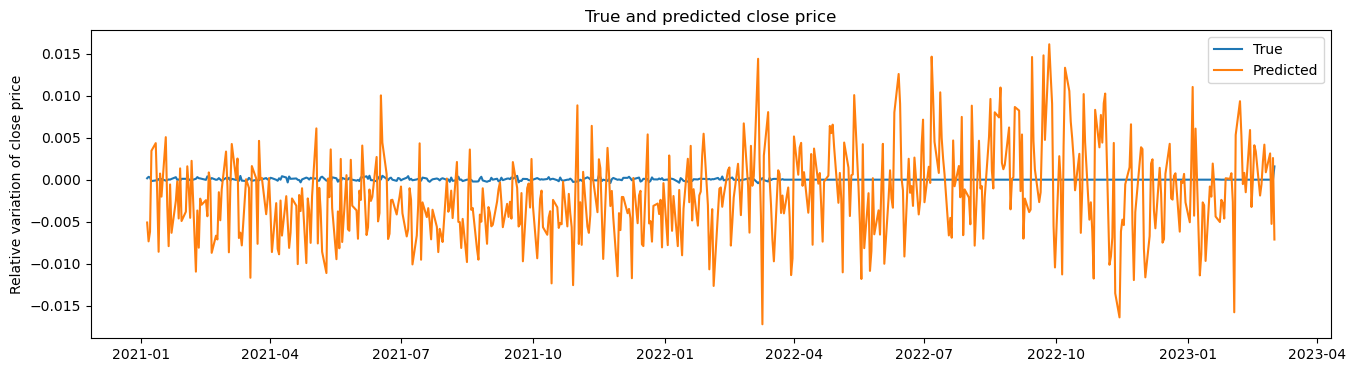

In [6]:
plt.figure(figsize=(16, 4))
plt.plot(rel_true)
plt.plot(rel_pred)
plt.legend(["True", "Predicted"])
plt.title("True and predicted close price")
plt.ylabel("Relative variation of close price")
plt.show()

This time by plotting the price variations, we clearly see the randomness of our model. It haven't been able to give us correct predictions.

Making Forex predictions is challenging because **the market is highly unpredictable and influenced by many variables**, including geopolitical events, economic indicators, and news releases. These variables are often interconnected and change frequently, making it difficult to develop a model that can capture all the nuances of the market.

Even with an LSTM model, predicting Forex is challenging because the model can only learn from past data, and it may not be able to capture **sudden market changes or unexpected events** that have not occurred in the past. Moreover, the data used to train the model may not be representative of future market conditions, and the model's accuracy may deteriorate over time as market conditions change.

However, it is still possible to develop a positive strategy for Forex trading, even though predictions **may not always be accurate.** A profitable strategy may involve a combination of technical and fundamental analysis, risk management, and market knowledge.